In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from scipy.linalg import solve_banded
from scipy.interpolate import interp1d
from scipy.optimize import brentq
from scipy.stats import norm

base_path = Path("/Users/kennethzhang/Desktop/VolAuction/data")
auction_quotes = pd.read_parquet(base_path / "auction_daily_quotes.parquet")
vol_df = pd.read_csv(base_path / "auction_vol_results.csv")
params_df = pd.read_csv(base_path / "jump_forecast_parameters.csv")
es_futures = pd.read_csv(base_path / "es_futures_1m_all.csv")
es_futures["Datetime"] = pd.to_datetime(es_futures["Datetime"])
es_futures["time"] = es_futures["Datetime"].dt.time
es_futures["date"] = es_futures["Datetime"].dt.date

In [38]:
open_prices = es_futures[es_futures["time"] == pd.to_datetime("09:30:00").time()][["date", "Close"]].rename(columns={"Close": "S0"})
open_prices["date"] = pd.to_datetime(open_prices["date"])
es_futures["date"] = pd.to_datetime(es_futures["date"])
auction_quotes["date"] = pd.to_datetime(auction_quotes["date"])
vol_df["date"] = pd.to_datetime(vol_df["date"])

In [39]:
merged_df = auction_quotes.merge(vol_df[["date", "AuctionIV"]], on="date", how="inner")
merged_df = merged_df.merge(open_prices, on="date", how="inner")
merged_df["K"] = merged_df["strike"] / 1000
merged_df["S0"] = merged_df["S0"].astype(float)
merged_df["K"] = merged_df["K"].astype(float)

In [40]:
simulated_paths = np.load(base_path / "simulated_paths.npy")
N = simulated_paths.shape[1]
dt = 1 / 390
T = N * dt
r = 0.0

In [41]:
def crank_nicolson_call_price(S0, K, T, sigma, r=0.0, N=100, M=200):
    S_max = S0 * 1.5
    S_min = S0 * 0.5
    dt = T / N
    dS = (S_max - S_min) / M
    grid = np.zeros((M+1, N+1))
    S_vals = np.linspace(S_min, S_max, M+1)

    grid[:, -1] = np.maximum(S_vals - K, 0)
    grid[0, :] = 0
    grid[-1, :] = S_max - K * np.exp(-r * dt * np.arange(N+1)[::-1])

    i_vals = np.arange(1, M)
    alpha = 0.25 * dt * (sigma**2 * (i_vals**2) - r * i_vals)
    beta = -0.5 * dt * (sigma**2 * (i_vals**2) + r)
    gamma = 0.25 * dt * (sigma**2 * (i_vals**2) + r * i_vals)

    for j in reversed(range(N)):
        A = np.zeros((3, M-1))
        B = np.zeros(M-1)
        A[0, 1:] = -alpha[1:]
        A[1, :]  = 1 - beta
        A[2, :-1] = -gamma[:-1]

        B = alpha * grid[i_vals - 1, j+1] + (1 + beta) * grid[i_vals, j+1] + gamma * grid[i_vals + 1, j+1]
        B[0]  -= alpha[0] * grid[0, j]
        B[-1] -= gamma[-1] * grid[-1, j]
        grid[i_vals, j] = solve_banded((1, 1), A, B)

    price_interpolator = interp1d(S_vals, grid[:, 0], kind='cubic')
    return price_interpolator(S0)

def bs_price_call(S, K, T, sigma, r=0.0):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

def iv_solver(target_price, S0, K, T):
    return brentq(lambda sigma: bs_price_call(S0, K, T, sigma) - target_price, 1e-5, 2)

In [43]:
results = []
for idx, row in tqdm(merged_df.iterrows(), total=len(merged_df)):
    S0 = row["S0"]
    K = row["K"]
    sigma = row.get("ForecastedVol", 0.011)
    cn_price = crank_nicolson_call_price(S0, K, T, sigma)
    model_iv = iv_solver(cn_price, S0, K, T)
    results.append({
        "date": row["date"],
        "S0": S0,
        "K": K,
        "CN_Price": cn_price,
        "Model_IV": model_iv,
        "Auction_IV": row["AuctionIV"],
        "IV_Edge": row["AuctionIV"] - model_iv
    })

results_df = pd.DataFrame(results)

100%|██████████| 6/6 [00:00<00:00, 206.64it/s]


In [44]:
results_df

,date,S0,K,CN_Price,Model_IV,Auction_IV,IV_Edge
0,2025-03-24,5776.25,5625.0,151.3051723755101,0.024869,0.001226,-0.023643
1,2025-03-25,5828.25,5685.0,143.30558202078544,0.023470,0.004460,-0.019010
2,2025-03-26,5826.00,5710.0,116.05530964396009,0.019376,0.003159,-0.016217
3,2025-03-27,5744.00,5590.0,154.05489779108737,0.025413,0.004910,-0.020503
4,2025-03-28,5722.75,1200.0,4522.845363160906,1.165904,0.010013,-1.155891
5,2025-03-31,5566.75,1200.0,4366.842459126766,1.145271,0.005119,-1.140152


In [46]:
results_df["AbsError"] = np.abs(results_df["Auction_IV"] - results_df["Model_IV"])
results_df["PctError"] = results_df["AbsError"] / results_df["Auction_IV"]

In [47]:
results_df

,date,S0,K,CN_Price,Model_IV,Auction_IV,IV_Edge,AbsError,PctError
0,2025-03-24,5776.25,5625.0,151.3051723755101,0.024869,0.001226,-0.023643,0.023643,19.283589
1,2025-03-25,5828.25,5685.0,143.30558202078544,0.023470,0.004460,-0.019010,0.019010,4.262295
2,2025-03-26,5826.00,5710.0,116.05530964396009,0.019376,0.003159,-0.016217,0.016217,5.133793
3,2025-03-27,5744.00,5590.0,154.05489779108737,0.025413,0.004910,-0.020503,0.020503,4.175537
4,2025-03-28,5722.75,1200.0,4522.845363160906,1.165904,0.010013,-1.155891,1.155891,115.436161
5,2025-03-31,5566.75,1200.0,4366.842459126766,1.145271,0.005119,-1.140152,1.140152,222.730120


In [48]:
iv_edge_mean = results_df["IV_Edge"].mean()
iv_edge_std = results_df["IV_Edge"].std()
results_df["ZScore"] = (results_df["IV_Edge"] - iv_edge_mean) / iv_edge_std

In [49]:
results_df

,date,S0,K,CN_Price,Model_IV,Auction_IV,IV_Edge,AbsError,PctError,ZScore
0,2025-03-24,5776.25,5625.0,151.3051723755101,0.024869,0.001226,-0.023643,0.023643,19.283589,0.638946
1,2025-03-25,5828.25,5685.0,143.30558202078544,0.023470,0.004460,-0.019010,0.019010,4.262295,0.646898
2,2025-03-26,5826.00,5710.0,116.05530964396009,0.019376,0.003159,-0.016217,0.016217,5.133793,0.651693
3,2025-03-27,5744.00,5590.0,154.05489779108737,0.025413,0.004910,-0.020503,0.020503,4.175537,0.644336
4,2025-03-28,5722.75,1200.0,4522.845363160906,1.165904,0.010013,-1.155891,1.155891,115.436161,-1.304444
5,2025-03-31,5566.75,1200.0,4366.842459126766,1.145271,0.005119,-1.140152,1.140152,222.730120,-1.277429


In [50]:
results_df["CorrectDirection"] = (results_df["IV_Edge"] < 0).astype(int)
accuracy = results_df["CorrectDirection"].mean()
print(f"Directional Accuracy (Model IV < Auction IV): {accuracy:.2%}")

Directional Accuracy (Model IV < Auction IV): 100.00%


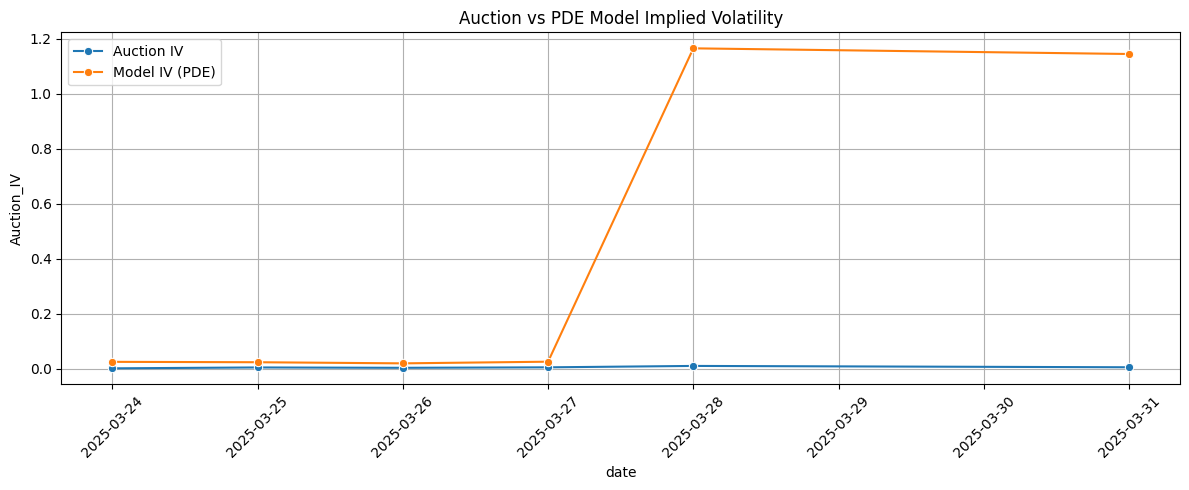

In [51]:
import seaborn as sns
plt.figure(figsize=(12, 5))
sns.lineplot(x="date", y="Auction_IV", data=results_df, label="Auction IV", marker="o")
sns.lineplot(x="date", y="Model_IV", data=results_df, label="Model IV (PDE)", marker="o")
plt.title("Auction vs PDE Model Implied Volatility")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

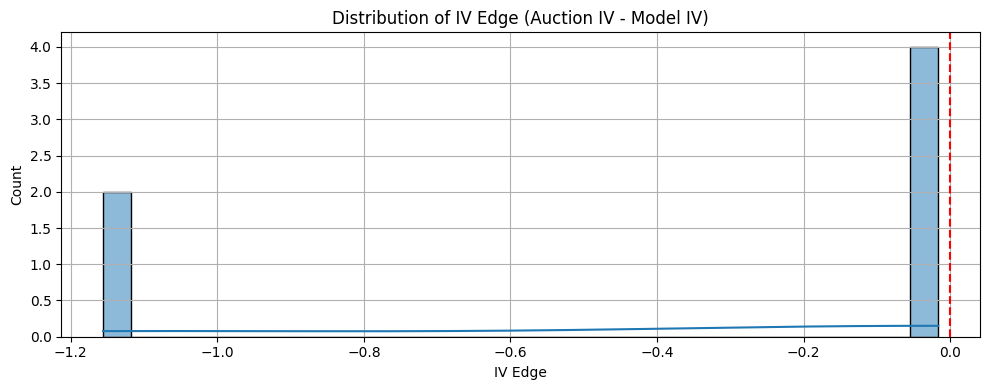

In [52]:
plt.figure(figsize=(10, 4))
sns.histplot(results_df["IV_Edge"], kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of IV Edge (Auction IV - Model IV)")
plt.xlabel("IV Edge")
plt.grid(True)
plt.tight_layout()
plt.show()

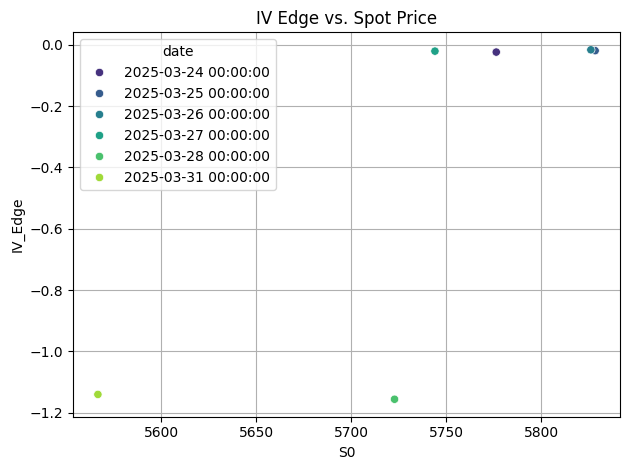

In [53]:
sns.scatterplot(data=results_df, x="S0", y="IV_Edge", hue="date", palette="viridis")
plt.title("IV Edge vs. Spot Price")
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/bc/0sv4l9h92yb5pz7_7vm4gh900000gn/T/ipykernel_89400/3626949534.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='date', y='ZScore', data=results_df.sort_values('ZScore'), palette="coolwarm")


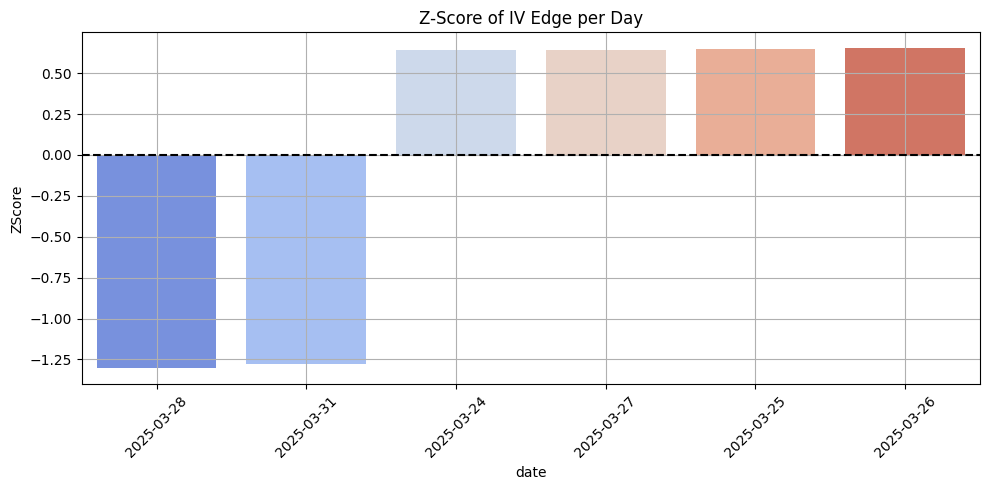

In [54]:
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.barplot(x='date', y='ZScore', data=results_df.sort_values('ZScore'), palette="coolwarm")
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.title("Z-Score of IV Edge per Day")
plt.tight_layout()
plt.grid(True)
plt.show()